https://www.kaggle.com/datasets/prathamtripathi/drug-classification класифікація ліків


https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009 класифікація вина

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, classification_report
from pandas.plotting import scatter_matrix
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV

2024-10-05 03:09:04.256392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def transform_column_and_check(column, dictionary): #для перетворення текстових значень
    column = column.apply(check_key_or_add, args = (dictionary,)) #використовуючи словник замінюємо текстові значення
    return column
def check_key_or_add(item, dictionary):
    if item not in dictionary: dictionary[item] = len(dictionary) 
        #додаємо до dictionary нове текстове значення якщо воно не існує, пара — довжтна dictionary
        #необхідно щоб dictionary виглядало як {text:0, text1:1, text2:2 ... text_n: n}
    return dictionary[item] #повертаю числове значення

In [3]:
def make_std(data, y_name):
    data_std = (data - data.mean())/data.std()
    data_std[y_name] = data[y_name]
    return data_std
def pre_processing(data, processed_columns, dictionary_pre_processing):
    for column in processed_columns: #проходимо по всім стовбчикам що не є числами
        if column in dictionary_pre_processing: #якщо є в dictionary_pre_processing використовуємо його
            data[column] = transform_column_and_check(data[column], dictionary_pre_processing[column])
        else:
            dictionary = {} #якщо нема, то починаємо з пустого
            data[column] = transform_column_and_check(data[column], dictionary)
            dictionary_pre_processing[column] = dictionary #оновлюю словник (може бути використано далі для перетворення)
    data[processed_columns] = data[processed_columns].apply(pd.to_numeric) #перетворюємо на число в самому dataframe
    

In [4]:
def info_show_pre_process(data):
    print(data.info())  #показати інформацію та
    print(data.describe()) #описати data
def info_show_post_process(data, drop_columns = []):
    plt.figure(figsize = (20, 10)) #надати розмір фігурі
    x = data.drop(drop_columns, axis = 1) #відкинути непотрібні стовбчики
    ax = sns.heatmap(data.corr(), annot = True, cmap = 'viridis') #кореляції тепловою мапою
    plt.show() #показати мапу
def show_classification_and_accuracy(X_train, X_test, y_train, y_test, classificator):
    print("test result:")
    pred = classificator.predict(X_test) #передбачення на тестовій частині
    print(pred)
    print("test clasification report:")
    print(classification_report(y_test, pred)) #репорт класифікації
    print("test accuracy score:")
    print(accuracy_score(y_test, pred)) #точність кваліфікатора класифікації
    
    pred = classificator.predict(X_train) #передбачення на тренувальній частині
    print("train clasification report:")
    print(classification_report(y_train, pred)) #репорт класифікації
    print("train accuracy score:")
    print(accuracy_score(y_train, pred)) #точність кваліфікатора класифікації
    
def show_accuracy(X_test, y_test, classificator, show_test_res = False):
    pred = classificator.predict(X_test) #передбачення на тестовій частині
    if show_test_res:
        print("test result:")
        print(pred)
    print("test accuracy score:")
    print(accuracy_score(y_test, pred)) #точність кваліфікатора класифікації

In [5]:
def train_and_report_knn(X_train, X_test, y_train, y_test, n_neighbors = [4], max_iter = 3000, show_test_res = False):
    knns = []
    for i in n_neighbors:
        start_time = datetime.now() #Початок
        knn = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski') #KNN класифікатор
        #створити KNN класифікатор, використовувати метрику Мінковського
        knn.fit(X_train, y_train) #тренувати класифікатор
        end_time = datetime.now() #Кінець
        print("KNN with", i, "neighbors:")
        print('Time spent on training:', str(end_time - start_time))
        show_accuracy(X_test, y_test, knn)
        knns.append(knn)
    return knns

In [6]:
#https://www.kaggle.com/datasets/prathamtripathi/drug-classification
#першоджерело датасету

In [7]:
data_drug_start=pd.read_csv("drug200.csv") #Читаємо всю інформацію

info_show_pre_process(data_drug_start) #показую інформацію щодо не обробленого датасету

counter = Counter(data_drug_start["Drug"])
print(counter)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB
None
              Age     Na_to_K
count  200.000000  200.000000
mean    44.315000   16.084485
std     16.544315    7.223956
min     15.000000    6.269000
25%     31.000000   10.445500
50%     45.000000   13.936500
75%     58.000000   19.380000
max     74.000000   38.247000
Counter({'DrugY': 91, 'drugX': 54, 'drugA': 23, 'drugC': 16, 'drugB': 16})


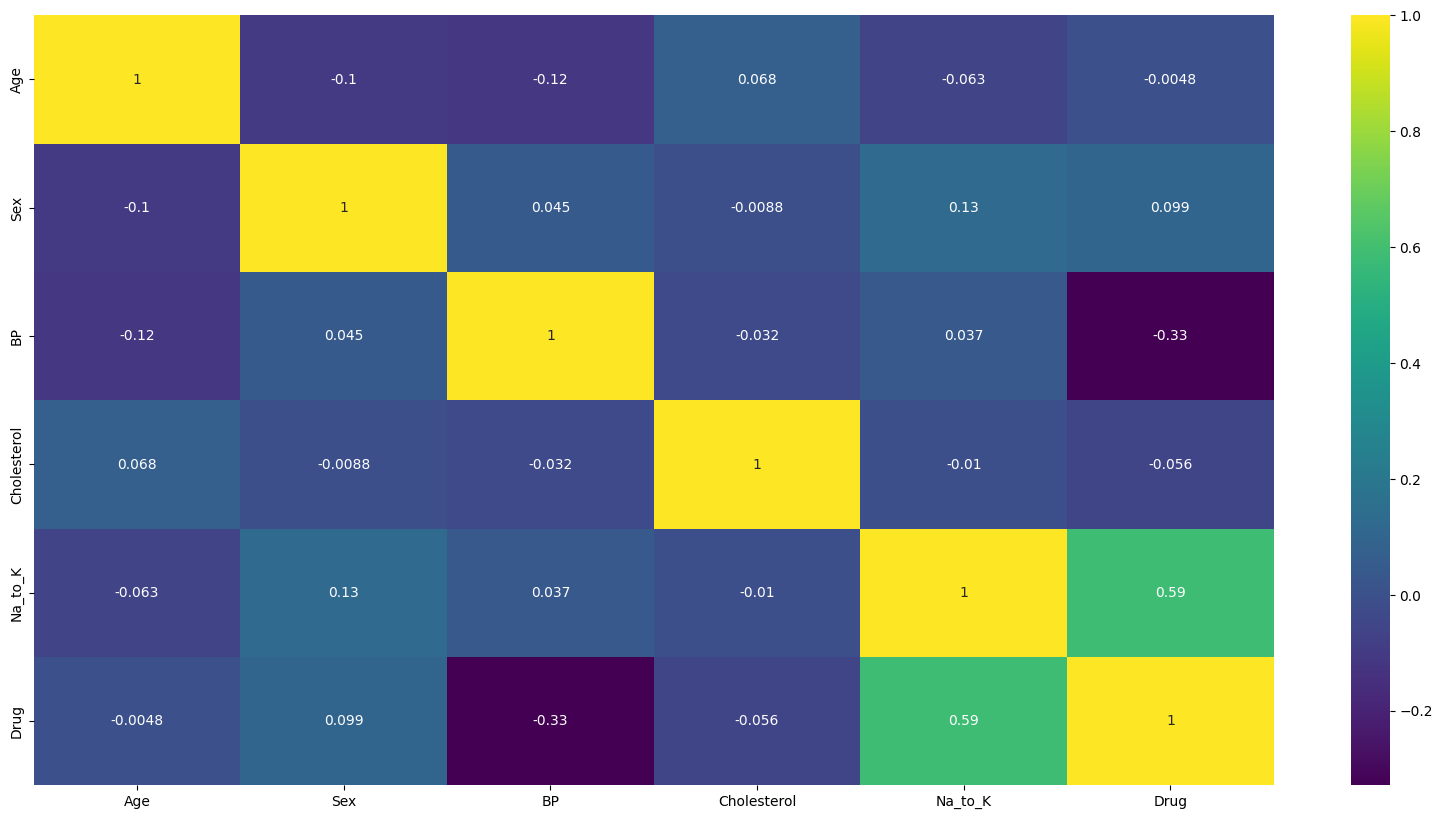

In [8]:
BP = {
    'LOW':0, 'NORMAL':1, 'HIGH':2
} #Словник для тиску крові
Cholesterol = {'LOW':0, 'NORMAL':1, 'HIGH':2} #Словник для холестирину
Sex = {'M': 0, 'F': 1} #Словник для статті
Drug = {'drugA': 0, 'drugB': 1, "drugC": 2, "drugX": 3, "DrugY": 4} #Словник для ліків
replace_dict_drug = {"BP":BP, "Cholesterol":Cholesterol, "Sex": Sex, 
                "Drug": Drug} #словник словників
pre_processing(data_drug_start, ["BP", "Cholesterol", "Sex", "Drug"], replace_dict_drug) #Замінити текст на числові значення

data_drug_std = make_std(data_drug_start, "Drug")

X = data_drug_std[data_drug_std.columns[:-1]] #Ігноруючи ліки
y = data_drug_std["Drug"] #шукаємо які ліки виписати
info_show_post_process(data_drug_std) #Створюю та показую мапу кореляцій

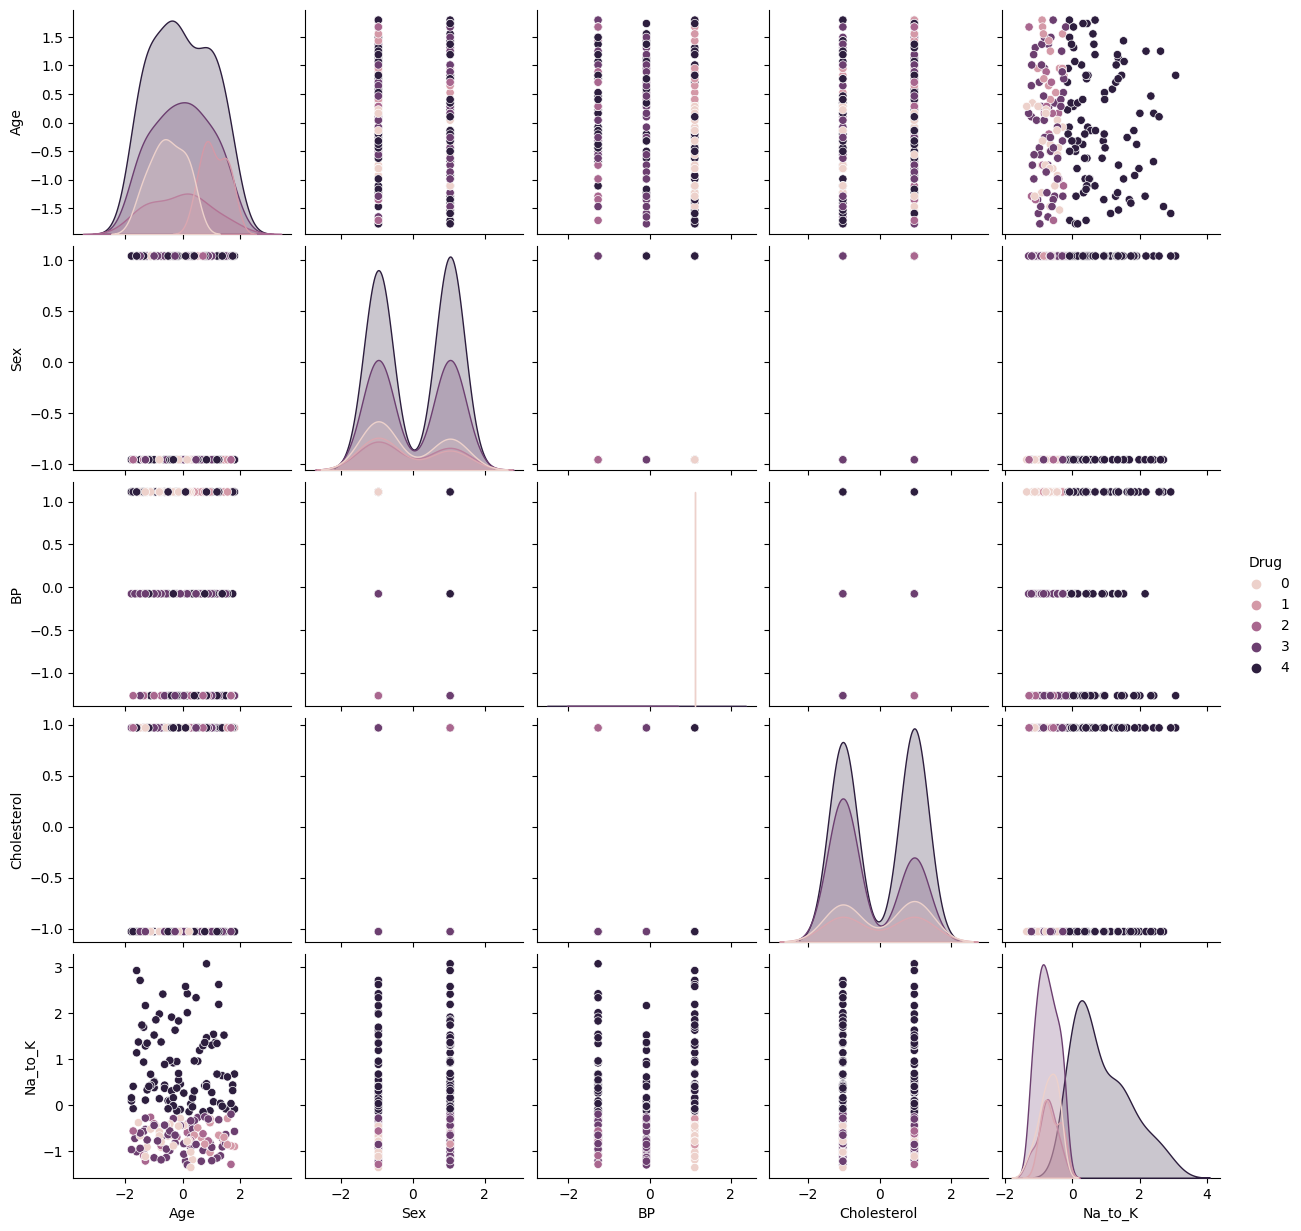

In [9]:
p_plot = sns.pairplot(data_drug_std, hue = "Drug")# діаграми на початкових даних

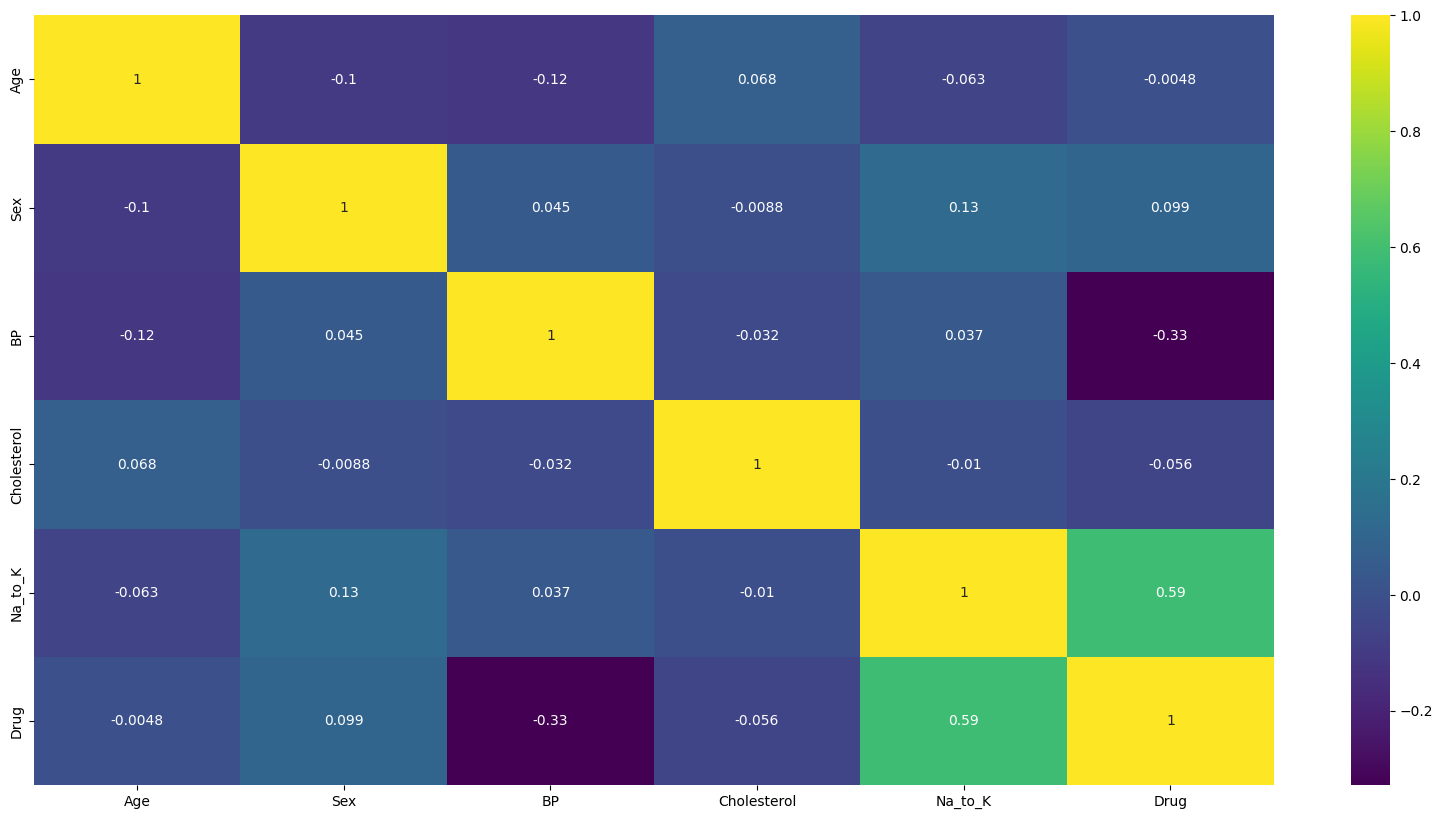

Counter({4: 91, 3: 54, 0: 23, 2: 16, 1: 16})


In [10]:
#oversample = SMOTE() #створюю SMOTE обʼєкт
#X_o, y_o = oversample.fit_resample(X, y) #SMOTE обʼєкт створює додаткові елементи недостатніх класів
info_show_post_process(X.join(y, lsuffix='_caller', rsuffix='_other')) #Створюю та показую мапу кореляцій з зміненими даними
counter = Counter(y)
print(counter)

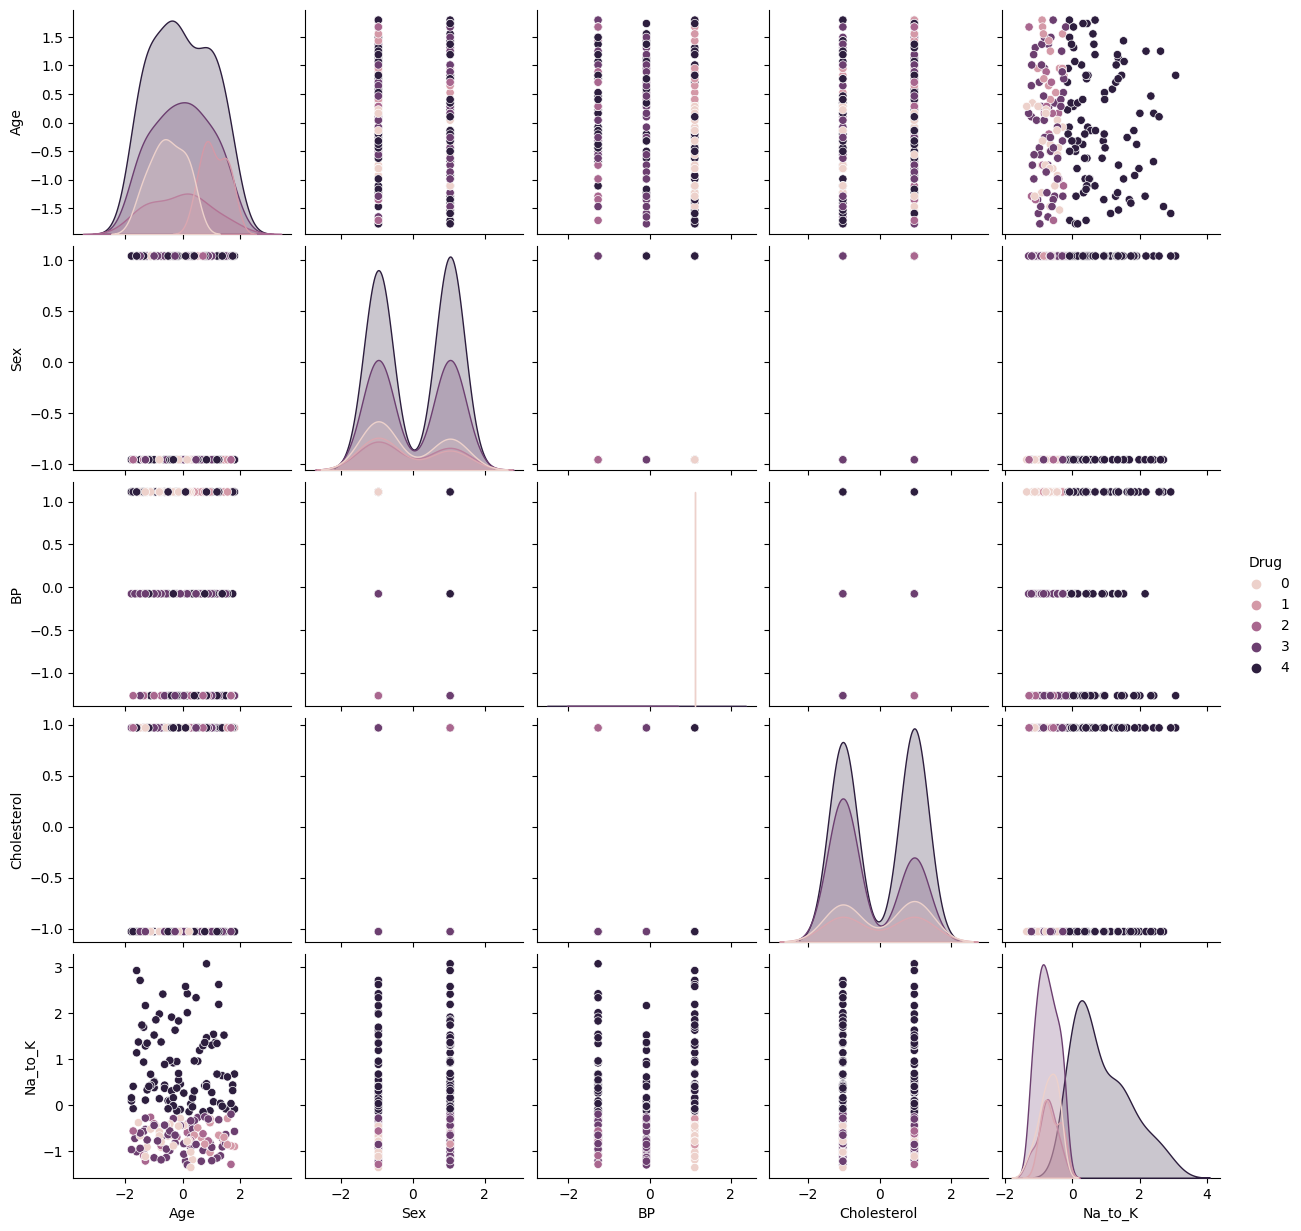

In [11]:
p_plot = sns.pairplot(X.join(y, lsuffix='_caller', rsuffix='_other'), hue = "Drug")
# діаграми на даних з доданими синтетичними елементами

In [12]:
def find_best_features(x_train, y_train, regressor, selected = 5):
    rfe = RFE(estimator = regressor, n_features_to_select = selected, step = 1) #створую RFE
    rfe = rfe.fit(x_train, y_train) #треную RFE
    return x_train.columns[rfe.support_] #повертаю найкраші для тренування регресора параметри
def show_result(regressor, X_test, y_test, title = "HeatMap using Seaborn Method"):
    predicted_test = regressor.predict(X_test) #класифікація на тесті
    ac = accuracy_score(y_test, predicted_test) #порахувати точність
    print("Accuracy is: ", ac)
    print()
    labels = list(Counter(y_test).keys()) #отримати labels для теплової картки
    cm2 = confusion_matrix(y_test, predicted_test) #створити матрицю
    plt.figure() #щоб теплові картки не наклалися один на одного
    plt.title(title) #назву додати
    #sns.heatmap(cm2, annot = True, fmt = "d", xticklabels=labels, yticklabels=labels, axis = 1) #намалювати теплову карту
    cmn = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cmn, annot = True, xticklabels=labels, yticklabels=labels) #намалювати теплову карту
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [13]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from datetime import datetime, timedelta
from sklearn.feature_selection import RFE

In [14]:
def show_result_tree(regressor, X_test, y_test, title = "HeatMap using Seaborn Method"):
    predicted_test = regressor.predict(X_test) #класифікація на тесті
    ac = accuracy_score(y_test, predicted_test) #порахувати точність
    print("Accuracy is: ", ac)
    print()
    labels = list(Counter(y_test).keys()) #отримати labels для теплової картки
    cm2 = confusion_matrix(y_test, predicted_test) #створити матрицю
    plt.figure() #щоб теплові картки не наклалися один на одного
    plt.title(title) #назву додати
    #sns.heatmap(cm2, annot = True, fmt = "d", xticklabels=labels, yticklabels=labels, axis = 1) #намалювати теплову карту
    #sns.heatmap(np.corrcoef(cm2), annot = True, xticklabels=labels, yticklabels=labels) #намалювати теплову карту

    cmn = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cmn, annot = True, xticklabels=labels, yticklabels=labels) #намалювати теплову карту
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    #sns.heatmap(cm2, annot = True, fmt = "d") #намалювати теплову карту
def train_and_report_tree(X_train, X_test, y_train, y_test, random_state):
    #тренування та репортування дерева прийняття рішень та ансамблю дерев
    #розподілити значення на тренувальні та тест
    print("decision tree regressor:")
    start_time = datetime.now()
    r_tree = DecisionTreeRegressor(random_state = random_state) #створюю регресор для дерева
    r_tree.fit(X_train, y_train) #треную
    
    end_time = datetime.now()
    all_val_time = end_time - start_time
    show_result_tree(r_tree, X_test, y_test, "Heatmap for tree") #описати результат
    
    start_time = datetime.now()
    best_features_tree = find_best_features(X_train, y_train, 
                             DecisionTreeRegressor(random_state = random_state),
                            ) #найкращі 5 параметрів для тренування
    
    print("best features for tree regression:", best_features_tree)
    x_best_train = X_train[best_features_tree] #тренувальні x
    x_best_test = X_test[best_features_tree] #тестувальні x    
    
    print("decision tree regressor using best features:")
    r_tree_b = DecisionTreeRegressor(random_state = random_state) #новий регресор
    r_tree_b.fit(x_best_train, y_train) #тренування
    end_time = datetime.now()
    best_values_time = end_time - start_time
    show_result_tree(r_tree_b, x_best_test, y_test, "Heatmap for tree using best features") #описати результат
    
    print("За", all_val_time , " дерево натренувалося на всій інформації")
    print("За ",best_values_time, " дерево натренувалося використовуючи найкращі дані та є в ", best_values_time/all_val_time , " раз швидще")
    
    print("random forest classifier:")
    
    start_time = datetime.now()
    clr_rf = RandomForestClassifier(random_state = random_state) #нова модель для "лісу" — ансамблінг дерев
    clr_rf.fit(X_train, y_train) #тренування
    end_time = datetime.now()
    all_val_time_forest = end_time - start_time
    
    show_result_tree(clr_rf, X_test, y_test, "Heatmap for forest")
    
    start_time = datetime.now()
    best_features_forest = find_best_features(X_train, y_train, 
                             RandomForestClassifier(random_state = random_state),
                            )
    print("best features for forest:",  best_features_forest)
    x_best_train = X_train[best_features_forest]  #тренувальні x
    x_best_test = X_test[best_features_forest] #тестувальні x
    
    
    print("random forest classifier using best features:")
    clr_rf_b = RandomForestClassifier(random_state = random_state) #нова модель
    clr_rf_b.fit(x_best_train, y_train) #натренована на 5 найкращих параметрах
    end_time = datetime.now()
    best_values_time_forest = end_time - start_time
    show_result_tree(clr_rf_b, x_best_test, y_test, "Heatmap for forest using best features")
    
    
    print("За", all_val_time_forest , " ансамбль дерев прийняття рішень натренувалося на всій інформації")
    print("За ",best_values_time, " ансамбль дерев прийняття рішень натренувалося використовуючи найкращі дані та є в ", best_values_time/all_val_time , " раз швидще")
    return (r_tree, r_tree_b, clr_rf, clr_rf_b, best_features_tree, best_features_forest)

In [15]:
from sklearn.svm import SVC
def train_and_report_SVM(X_train, X_test, y_train, y_test, random_state, gamma, C, kernel = "rbf"):
    #time.time()
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state) 
    svm = SVC(kernel = kernel, random_state = random_state, gamma = gamma, C = C)
    svm.fit(X_train, y_train)
    print("SVM on training:")
    show_accuracy(X_test, y_test, svm)
    return svm

In [16]:
def train_and_report_ada(X_train, X_test, y_train, y_test, n_estimators = 50, learning_rate=1.0):
    ada = AdaBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate)
    ada.fit(X_train, y_train)
    print("AdaBoosterClasifier on training:")
    show_accuracy(X_train, y_train, ada)
    print("AdaBoosterClasifier on testing:")
    show_accuracy(X_test, y_test, ada)
    return ada

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 131)

In [18]:
drug_knns = train_and_report_knn(X_train, X_test, y_train, y_test, [4, 5], 100) #тренування KNN з 4, 5 сусідами; MLP 100 максимум ітерацій; з випадковим станом 131

KNN with 4 neighbors:
Time spent on training: 0:00:00.001872
test accuracy score:
0.8333333333333334
KNN with 5 neighbors:
Time spent on training: 0:00:00.001399
test accuracy score:
0.7666666666666667


In [19]:
y_pred = drug_knns[0].predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       1.00      0.80      0.89         5
           2       1.00      0.50      0.67         6
           3       0.91      0.91      0.91        22
           4       0.69      1.00      0.82        18

    accuracy                           0.83        60
   macro avg       0.92      0.75      0.80        60
weighted avg       0.87      0.83      0.83        60



Accuracy is:  0.8333333333333334



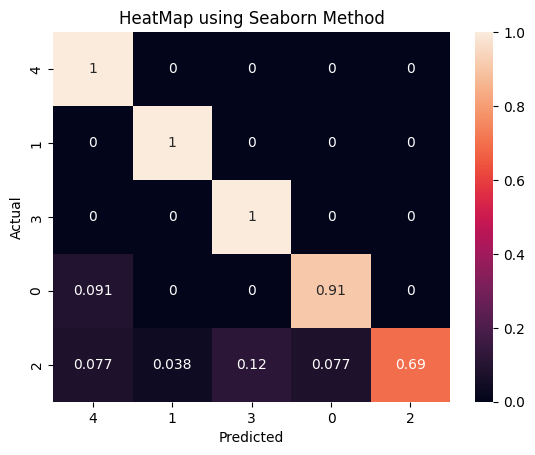

In [20]:
show_result(drug_knns[0], X_test, y_test)

decision tree regressor:
Accuracy is:  1.0

best features for tree regression: Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object')
decision tree regressor using best features:
Accuracy is:  1.0

За 0:00:00.002272  дерево натренувалося на всій інформації
За  0:00:00.004173  дерево натренувалося використовуючи найкращі дані та є в  1.8367077464788732  раз швидще
random forest classifier:
Accuracy is:  0.9833333333333333

best features for forest: Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object')
random forest classifier using best features:
Accuracy is:  0.9833333333333333

За 0:00:00.119919  ансамбль дерев прийняття рішень натренувалося на всій інформації
За  0:00:00.004173  ансамбль дерев прийняття рішень натренувалося використовуючи найкращі дані та є в  1.8367077464788732  раз швидще


(DecisionTreeRegressor(random_state=131),
 DecisionTreeRegressor(random_state=131),
 RandomForestClassifier(random_state=131),
 RandomForestClassifier(random_state=131),
 Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object'),
 Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object'))

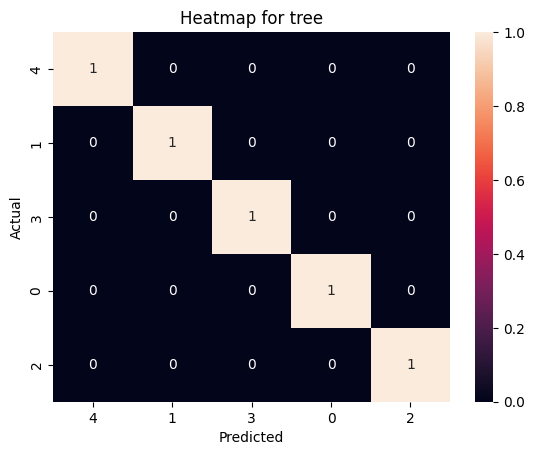

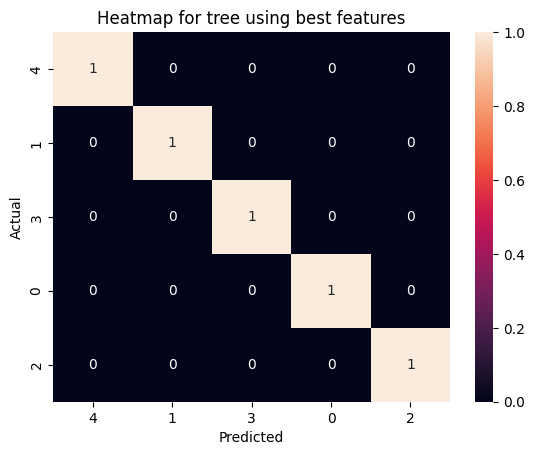

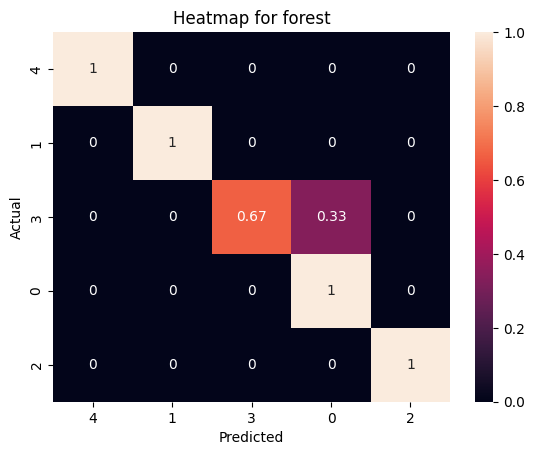

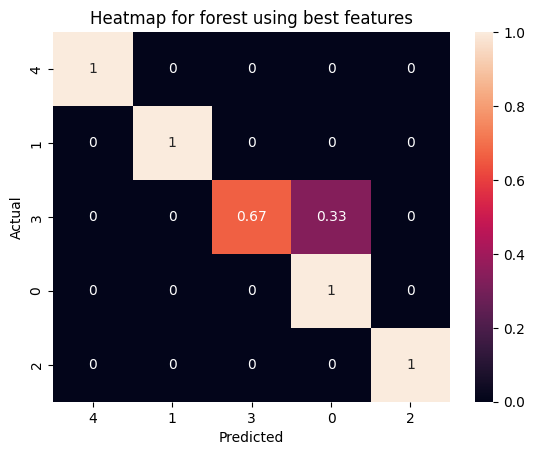

In [21]:
train_and_report_tree(X_train, X_test, y_train, y_test, 131)

In [22]:
clf = GridSearchCV(SVC(), {'C':[0.1, 0.25, 0.5, 0.7, 0.9, 1, 2], "gamma": [0.1, 0.25, 0.5, 0.7, 0.9, 1], "kernel" : ["rbf", "poly", "linear", "sigmoid"]})

In [23]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.25, 0.5, 0.7, 0.9, 1, 2],
                         'gamma': [0.1, 0.25, 0.5, 0.7, 0.9, 1],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']})

In [24]:
params = clf.best_params_
params

{'C': 2, 'gamma': 0.1, 'kernel': 'linear'}

In [25]:
svm = train_and_report_SVM(X_train, X_test, y_train, y_test, 131, params['C'], params['gamma'], params['kernel'])


SVM on training:
test accuracy score:
0.9166666666666666


Accuracy is:  0.9166666666666666



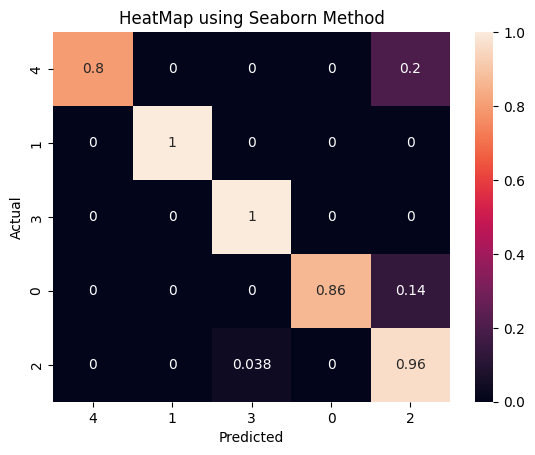

In [26]:
show_result(svm, X_test, y_test)

In [27]:
ada_dr = train_and_report_ada(X_train, X_test, y_train, y_test)

AdaBoosterClasifier on training:
test accuracy score:
0.8214285714285714
AdaBoosterClasifier on testing:
test accuracy score:
0.8833333333333333


Accuracy is:  0.8833333333333333



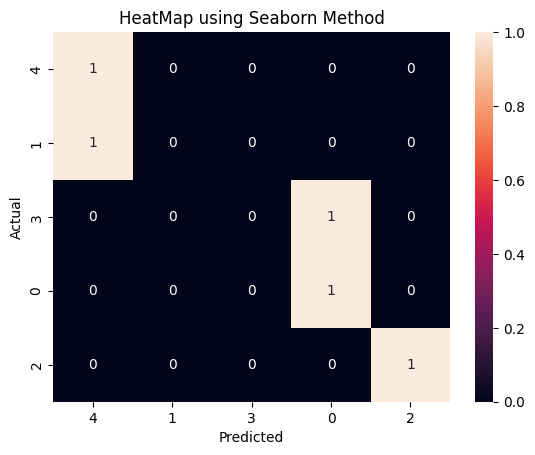

In [28]:
show_result(ada_dr, X_test, y_test)

In [29]:
data_wine = pd.read_csv("winequality-red.csv")

info_show_pre_process(data_wine) #показую інформацію щодо не обробленого датасету

counter_w = Counter(data_wine["quality"])
print(counter_w)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.00000

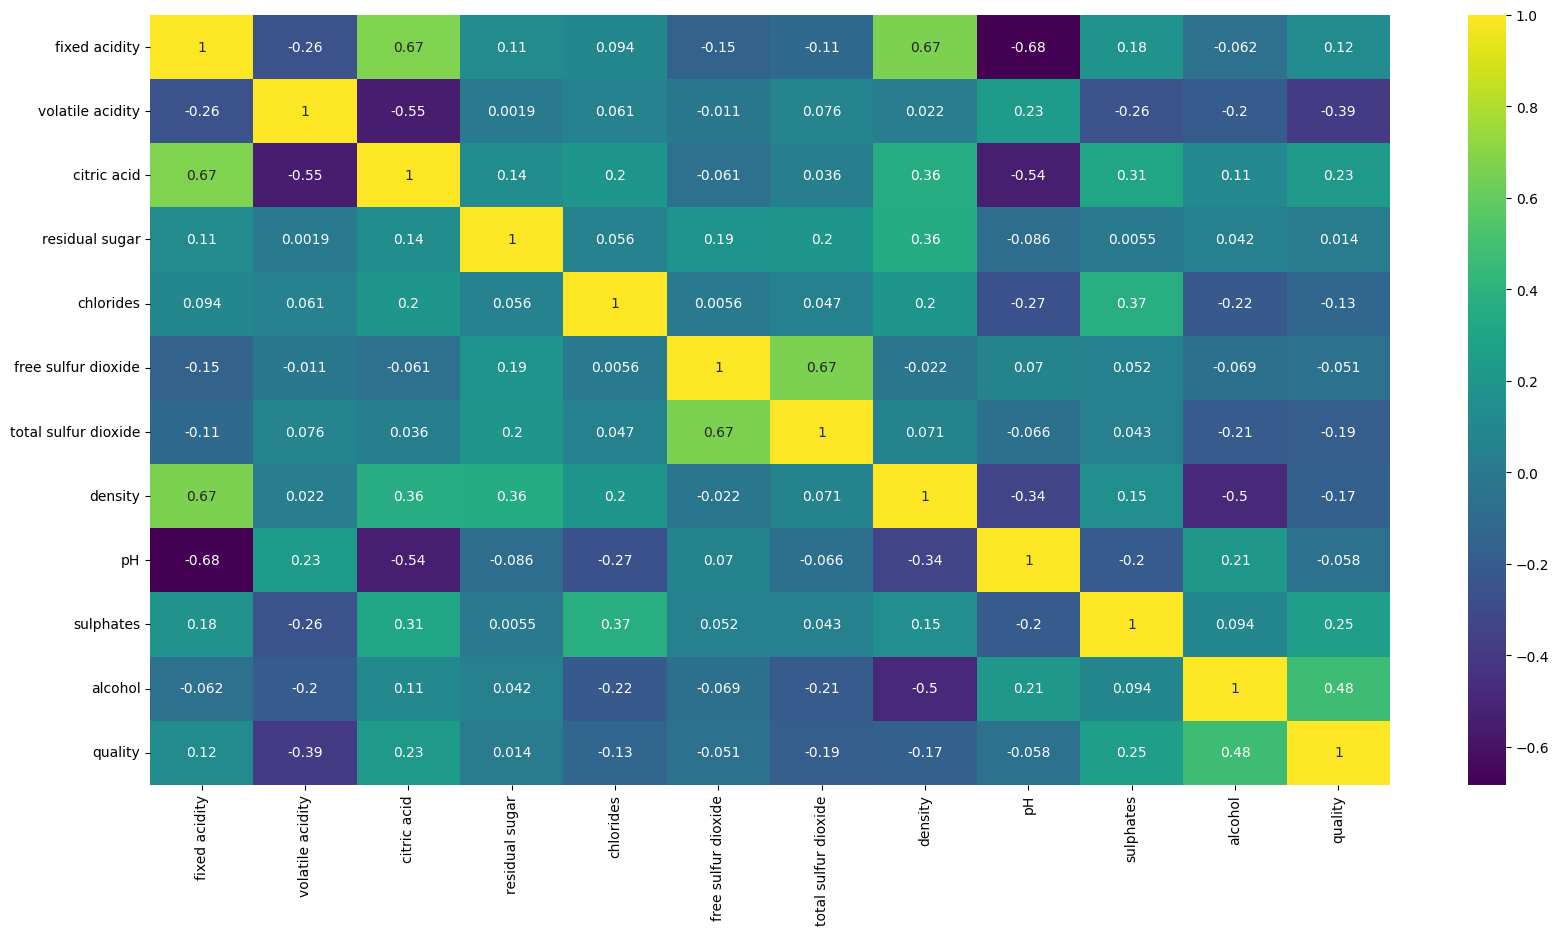

In [30]:
wine_drug_std = make_std(data_wine, "quality")

X_w = wine_drug_std[wine_drug_std.columns[:-1]] #Ігноруючи ліки
y_w = wine_drug_std["quality"] #шукаємо які ліки виписати
info_show_post_process(wine_drug_std) #Створюю та показую мапу кореляцій

In [31]:
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w, y_w, test_size = 0.3, random_state = 131)

In [32]:
train_and_report_knn(X_w_train, X_w_test, y_w_train, y_w_test, [3, 4, 5, 6], 1000) #тренування KNN з 4, 5 сусідами; MLP 100 максимум ітерацій; з випадковим станом 131

KNN with 3 neighbors:
Time spent on training: 0:00:00.001995
test accuracy score:
0.5708333333333333
KNN with 4 neighbors:
Time spent on training: 0:00:00.001948
test accuracy score:
0.5791666666666667
KNN with 5 neighbors:
Time spent on training: 0:00:00.001682
test accuracy score:
0.5729166666666666
KNN with 6 neighbors:
Time spent on training: 0:00:00.001784
test accuracy score:
0.5520833333333334


[KNeighborsClassifier(n_neighbors=3),
 KNeighborsClassifier(n_neighbors=4),
 KNeighborsClassifier(),
 KNeighborsClassifier(n_neighbors=6)]

decision tree regressor:
Accuracy is:  0.59375

best features for tree regression: Index(['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates',
       'alcohol'],
      dtype='object')
decision tree regressor using best features:
Accuracy is:  0.6083333333333333

За 0:00:00.007097  дерево натренувалося на всій інформації
За  0:00:00.039304  дерево натренувалося використовуючи найкращі дані та є в  5.53811469635057  раз швидще
random forest classifier:
Accuracy is:  0.6791666666666667

best features for forest: Index(['volatile acidity', 'total sulfur dioxide', 'density', 'sulphates',
       'alcohol'],
      dtype='object')
random forest classifier using best features:
Accuracy is:  0.6541666666666667

За 0:00:00.261356  ансамбль дерев прийняття рішень натренувалося на всій інформації
За  0:00:00.039304  ансамбль дерев прийняття рішень натренувалося використовуючи найкращі дані та є в  5.53811469635057  раз швидще


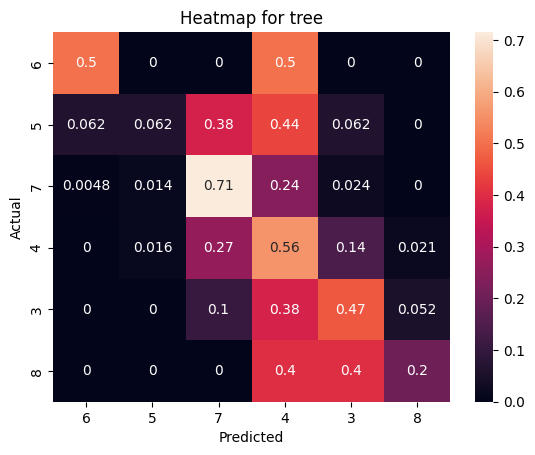

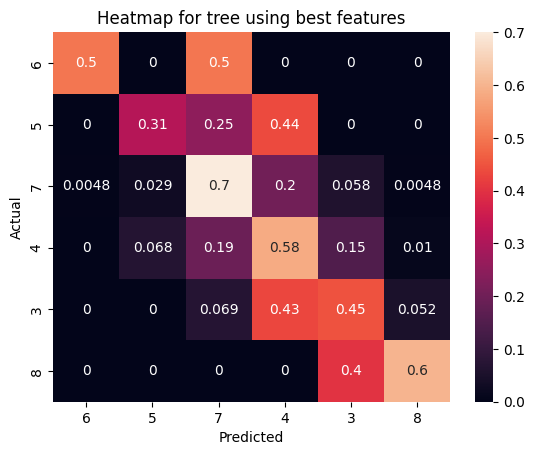

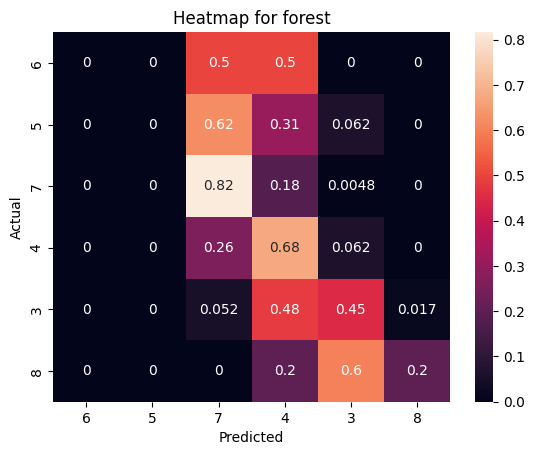

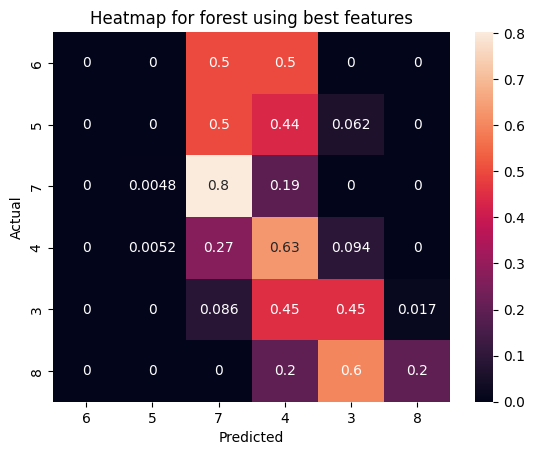

In [33]:
des_tree_1w, des_tree_2w, des_for_1w, des_for_2w, best_features_tree_w, best_features_forest_w = train_and_report_tree(X_w_train, X_w_test, y_w_train, y_w_test, 131)

In [34]:
oversample = SMOTE() #створюю SMOTE обʼєкт
Xw_o, yw_o = oversample.fit_resample(X_w_train, y_w_train) #SMOTE обʼєкт створює додаткові елементи недостатніх класів
Xw_o_train, Xw_o_test, yw_o_train, yw_o_test = train_test_split(Xw_o, yw_o, test_size = 0.3, random_state = 131)

decision tree regressor:
Accuracy is:  0.5333333333333333

best features for tree regression: Index(['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates',
       'alcohol'],
      dtype='object')
decision tree regressor using best features:
Accuracy is:  0.4895833333333333

За 0:00:00.015701  дерево натренувалося на всій інформації
За  0:00:00.085116  дерево натренувалося використовуючи найкращі дані та є в  5.421055983695306  раз швидще
random forest classifier:
Accuracy is:  0.6104166666666667

best features for forest: Index(['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates',
       'alcohol'],
      dtype='object')
random forest classifier using best features:
Accuracy is:  0.58125

За 0:00:00.431679  ансамбль дерев прийняття рішень натренувалося на всій інформації
За  0:00:00.085116  ансамбль дерев прийняття рішень натренувалося використовуючи найкращі дані та є в  5.421055983695306  раз швидще


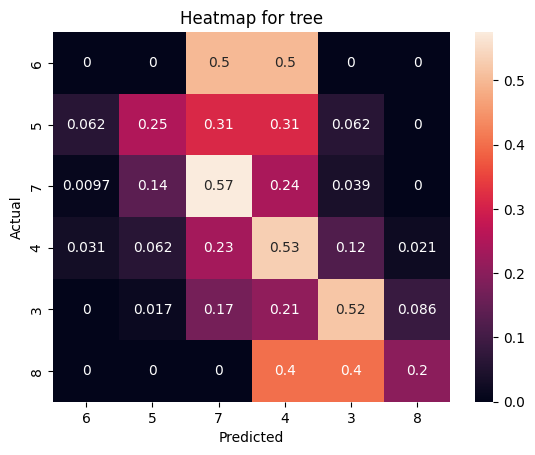

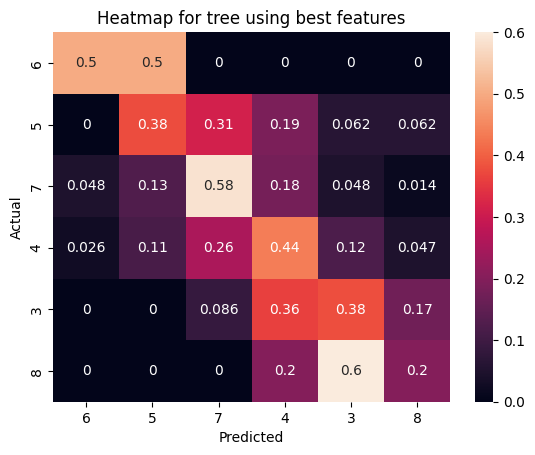

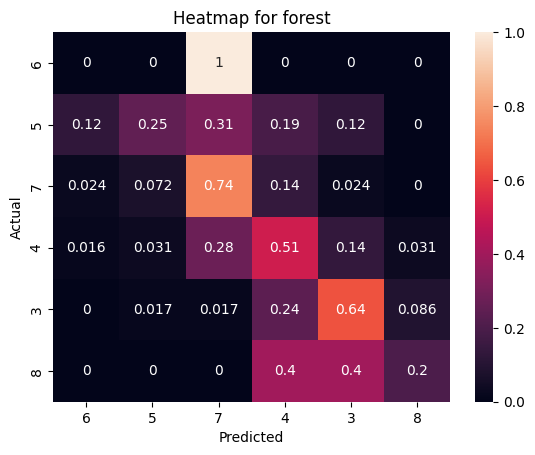

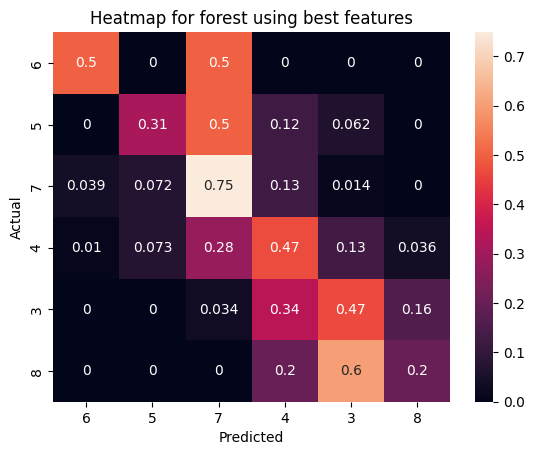

In [35]:
des_tree_1w_o, des_tree_bw_o, des_forest_1w_o, des_forest_bw_o, best_features_tree_w, best_features_forest_w = train_and_report_tree(Xw_o_train, X_w_test, yw_o_train, y_w_test, 131)

In [36]:
svm = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.5, 1.0, "poly")
svm = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.9, 1.0, "poly")
svm = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.5, 1.5, "poly")

SVM on training:
test accuracy score:
0.56875
SVM on training:
test accuracy score:
0.5604166666666667
SVM on training:
test accuracy score:
0.5708333333333333


In [37]:
svm = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.5, 1.0, "rbf")

SVM on training:
test accuracy score:
0.65


In [38]:
svm = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.5, 1.0, "sigmoid")

SVM on training:
test accuracy score:
0.44166666666666665


In [39]:
svm = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.5, 1.0, "linear")

SVM on training:
test accuracy score:
0.6104166666666667


In [40]:
svm = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.9, 1.0, "rbf")

SVM on training:
test accuracy score:
0.6416666666666667


In [41]:
svm = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.5, 1.2, "rbf")

SVM on training:
test accuracy score:
0.6458333333333334


In [42]:
svm = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.54, 1.0, "rbf")

SVM on training:
test accuracy score:
0.65625


In [43]:
ada_w = train_and_report_ada(X_w_train, X_w_test, y_w_train, y_w_test)

AdaBoosterClasifier on training:
test accuracy score:
0.5406613047363718
AdaBoosterClasifier on testing:
test accuracy score:
0.55


In [44]:
ada_w_o = train_and_report_ada(Xw_o_train, X_w_test, yw_o_train, y_w_test)

AdaBoosterClasifier on training:
test accuracy score:
0.29346733668341707
AdaBoosterClasifier on testing:
test accuracy score:
0.07916666666666666


In [45]:
ada_res_w = train_and_report_ada(X_w_train, X_w_test, y_w_train, y_w_test, learning_rate= 1.1, n_estimators = 600)

AdaBoosterClasifier on training:
test accuracy score:
0.546916890080429
AdaBoosterClasifier on testing:
test accuracy score:
0.5395833333333333


In [46]:
ada_res_w = train_and_report_ada(X_w_train, X_w_test, y_w_train, y_w_test, learning_rate= 0.9, n_estimators = 600)

AdaBoosterClasifier on training:
test accuracy score:
0.3646112600536193
AdaBoosterClasifier on testing:
test accuracy score:
0.35833333333333334


Accuracy is:  0.55



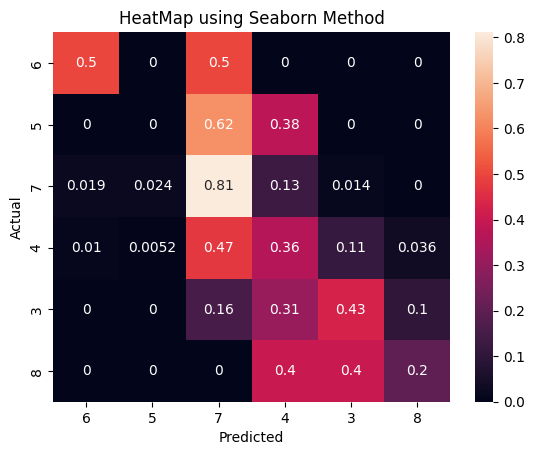

In [47]:
show_result(ada_w, X_w_test, y_w_test)

In [48]:
clf_w = GridSearchCV(SVC(), {'C':[0.1, 0.25, 0.5, 0.7, 0.9, 1, 2], "gamma": [0.1, 0.25, 0.5, 0.7, 0.9, 1], "kernel" : ["rbf", "poly", "linear", "sigmoid"]})

In [49]:
clf_w.fit(X_w_train, y_w_train) 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.25, 0.5, 0.7, 0.9, 1, 2],
                         'gamma': [0.1, 0.25, 0.5, 0.7, 0.9, 1],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']})

In [50]:
params_w = clf_w.best_params_
params_w

{'C': 1, 'gamma': 0.9, 'kernel': 'rbf'}

In [51]:
svm_w_best_par = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, params_w['C'], params_w['gamma'], params_w['kernel'])

SVM on training:
test accuracy score:
0.6479166666666667


Accuracy is:  0.6479166666666667



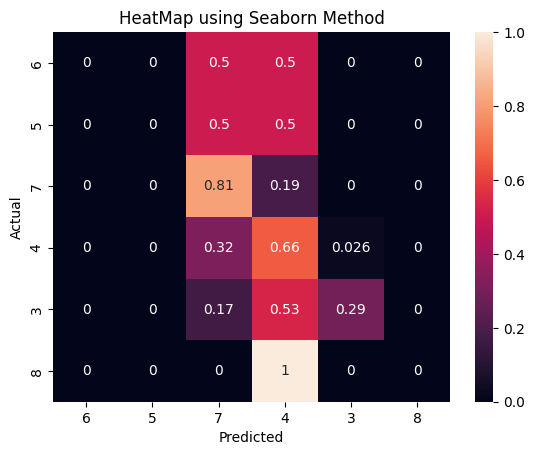

In [52]:
show_result(svm_w_best_par, X_w_test, y_w_test)

In [53]:
svm_w = train_and_report_SVM(X_w_train, X_w_test, y_w_train, y_w_test, 131, 0.5, 0.5, "rbf")

SVM on training:
test accuracy score:
0.6270833333333333


Accuracy is:  0.6270833333333333



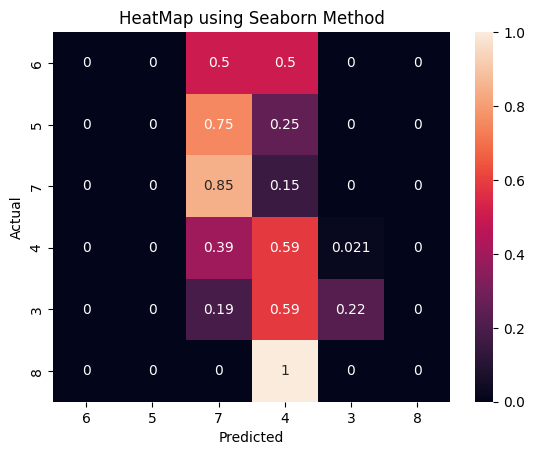

In [54]:
show_result(svm_w, X_w_test, y_w_test)

In [55]:
clf_w_o = GridSearchCV(SVC(), {'C':[0.1, 0.25, 0.5, 0.7, 0.9, 1, 2], "gamma": [0.1, 0.25, 0.5, 0.7, 0.9, 1], "kernel" : ["rbf", "poly", "linear", "sigmoid"]})

In [56]:
clf_w_o.fit(Xw_o, yw_o)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.25, 0.5, 0.7, 0.9, 1, 2],
                         'gamma': [0.1, 0.25, 0.5, 0.7, 0.9, 1],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']})

In [57]:
params_w_o = clf_w_o.best_params_
params_w_o

{'C': 2, 'gamma': 1, 'kernel': 'rbf'}

In [58]:
svm_w_best_par_o = train_and_report_SVM(Xw_o, X_w_test, yw_o, y_w_test, 131, params_w_o['C'], params_w_o['gamma'], params_w_o['kernel'])

SVM on training:
test accuracy score:
0.6395833333333333


Accuracy is:  0.6395833333333333



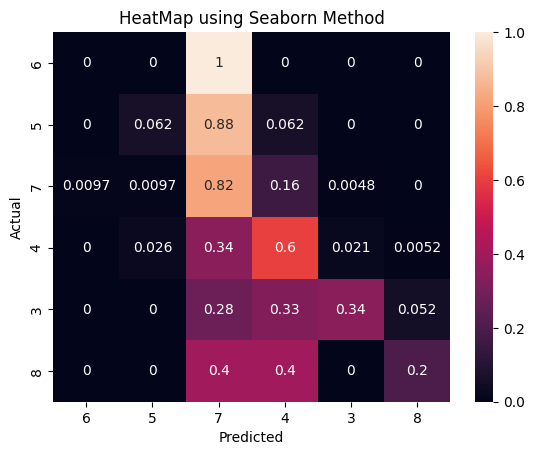

In [59]:
show_result(svm_w_best_par_o, X_w_test, y_w_test)